**7. algoritmos de procesamiento de imágenes**




**Faces recognition**

**En que Consiste el Algoritmo:**  El proceso de reconocimiento facial generalmente se divide en dos etapas principales: el entrenamiento y el reconocimiento propiamente dicho. se basa en que cada rostro tiene distinto rasgos como lo son la nariz, boca, cejas , pestañas entre otros. Analaizando una gran cantidad de images.

**Explicación de resultados:** 
Se aplica el analisis a la base de datos de imagenes de caras propias se aplica una evaluacion cuantitativa predicciones usando matplotlib y se constrye una cuadricula de las imagenes procesada y se predice en base al analaisis el nombre de la persona que se logra identificar con los rasgo faciales entonctrado.


**DataSet:** http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz 




In [11]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

Descargando los datos

In [36]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspeccione las matrices de imágenes para encontrar las formas (para trazar)
n_samples, h, w = lfw_people.images.shape

# para el aprendizaje automático usamos los 2 datos directamente (como píxel relativo
# información de posiciones es ignorada por este modelo)
X = lfw_people.data
n_features = X.shape[1]

# la etiqueta a predecir es el id de la persona
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Tamaño total del conjunto de datos:")
print("n_muestras: %d" % n_samples)
print("n_características: %d" % n_features)
print("n_clases: %d" % n_classes)

Tamaño total del conjunto de datos:
n_muestras: 1288
n_características: 1850
n_clases: 7


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
n_components = 150

print(
    "Extrayendo la parte superior %d caras propias de %d caras" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("Echo en %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Proyectar los datos de entrada sobre la base ortonormal de las caras propias")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Echo en %0.3fs" % (time() - t0))

Extrayendo la parte superior 150 caras propias de 966 caras
Echo en 0.800s
Proyectar los datos de entrada sobre la base ortonormal de las caras propias
Echo en 0.071s


In [23]:
print("Ajuste del clasificador al conjunto de entrenamiento")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("Echo en %0.3fs" % (time() - t0))
print("Mejor estimador encontrado por búsqueda en cuadrícula:")
print(clf.best_estimator_)

Ajuste del clasificador al conjunto de entrenamiento
Echo en 9.177s
Mejor estimador encontrado por búsqueda en cuadrícula:
SVC(C=4891.127187114485, class_weight='balanced', gamma=0.0006588717301871)


Evaluación cuantitativa de la calidad del modelo en el conjunto de prueba



Predecir los nombres de las personas en el conjunto de prueba
Echo en 0.290s
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.62      0.70        13
     Colin Powell       0.76      0.88      0.82        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.86      0.97      0.91       146
Gerhard Schroeder       1.00      0.76      0.86        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.93      0.75      0.83        36

         accuracy                           0.85       322
        macro avg       0.87      0.74      0.79       322
     weighted avg       0.86      0.85      0.85       322



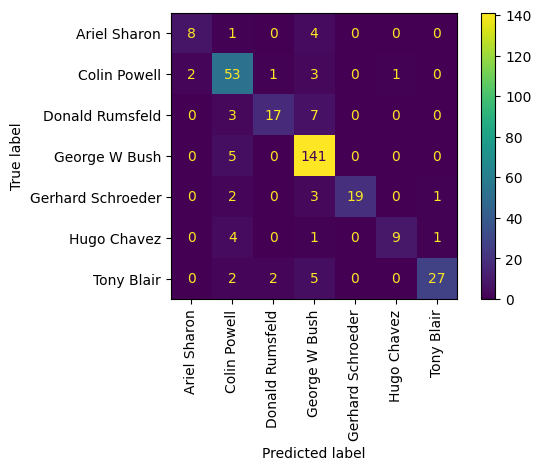

In [18]:
print("Predecir los nombres de las personas en el conjunto de prueba")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("Echo en %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Evaluación cualitativa de las predicciones usando matplotlib



In [24]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Función auxiliar para trazar una galería de retratos"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

trazar el resultado de la predicción en una parte del conjunto de prueba



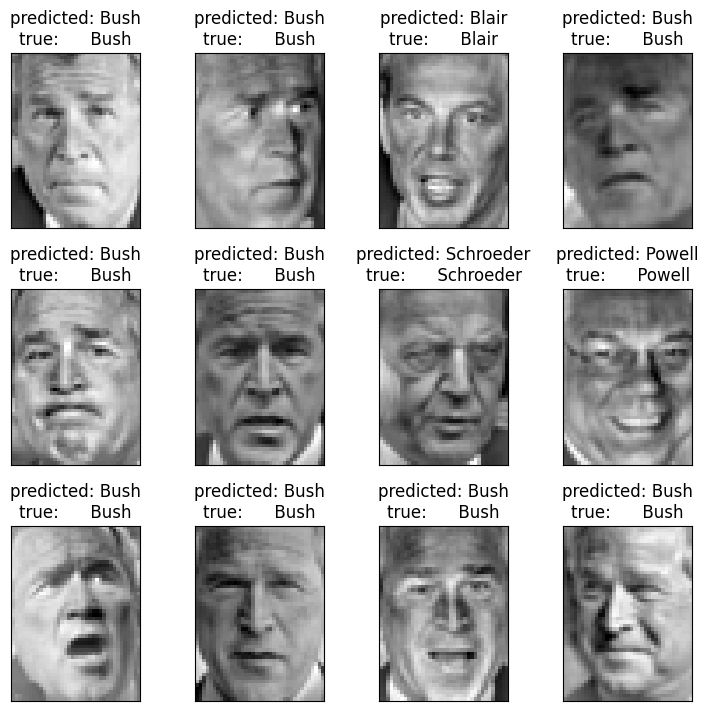

In [28]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

trazar la galería de las caras propias más significativas



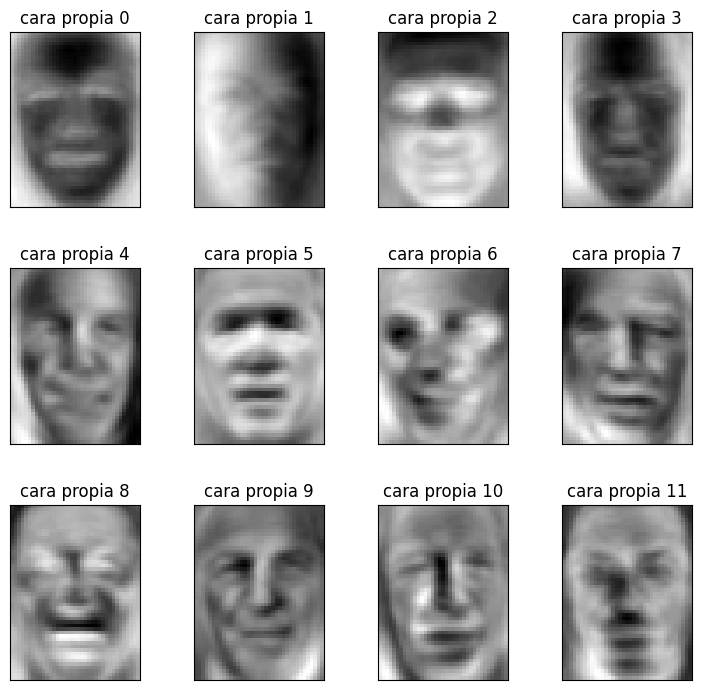

In [33]:
eigenface_titles = ["cara propia %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()